In [63]:
# 사진 갯수
from glob import glob
pngs = sorted(glob('unzip/*/*/*/*/*.png')) 
len(pngs)

473351

In [64]:
# 파일명 파싱
from tqdm.auto import tqdm
print(pngs[-1])
%time names = [e.split('/')[-1].split('.')[0].split('_') for e in pngs]
J = lambda n, i: '_'.join(n[:i])
A = lambda n: [J(n,1), J(n,2), J(n,3) , J(n,4), J(n,5)]
%time rows = [A(n) + [p] for n, p in zip(names, pngs)]
rows[-2:]

unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20397.png
CPU times: user 440 ms, sys: 32.5 ms, total: 473 ms
Wall time: 469 ms
CPU times: user 1.53 s, sys: 71.6 ms, total: 1.6 s
Wall time: 1.6 s


[['OUT',
  'OUT_H00646',
  'OUT_H00646_SN4',
  'OUT_H00646_SN4_100810',
  'OUT_H00646_SN4_100810_20394',
  'unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20394.png'],
 ['OUT',
  'OUT_H00646',
  'OUT_H00646_SN4',
  'OUT_H00646_SN4_100810',
  'OUT_H00646_SN4_100810_20397',
  'unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20397.png']]

In [65]:
# 데이터 프레임으로 변환
import pandas as pd
df = pd.DataFrame(rows, columns=['inout', 'H', 'SN', 'ID', 'PNG', 'path'])
df.tail(5)

,inout,H,SN,ID,PNG,path
473346,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20385,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473347,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20388,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473348,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20391,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473349,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20394,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473350,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20397,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...


In [66]:
# 컬럼별  nuique 통계
df.describe().loc[['unique']]

,inout,H,SN,ID,PNG,path
unique,2,102,401,3981,473351,473351


OUT_H00593



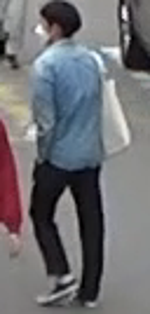
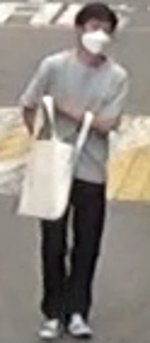
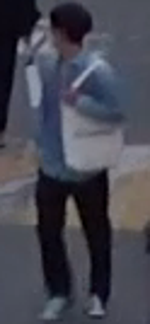
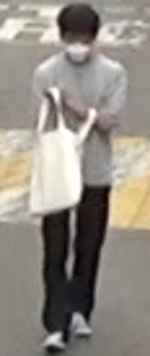
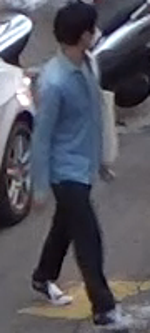
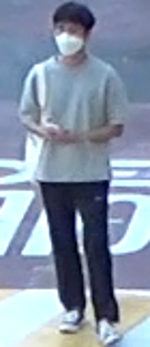
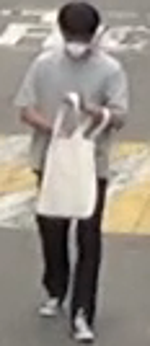
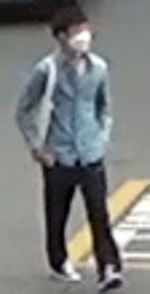
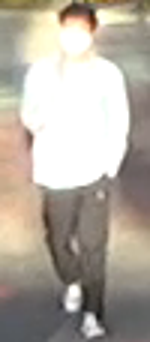
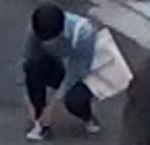


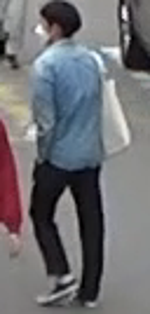
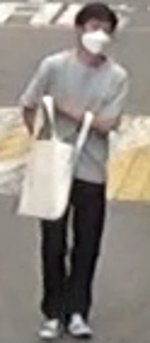
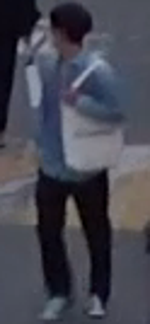
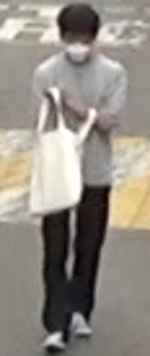
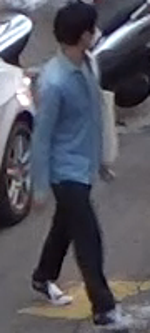
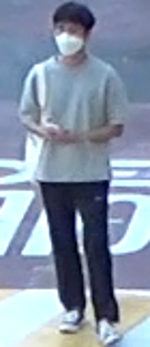
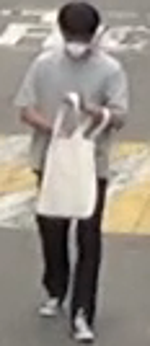
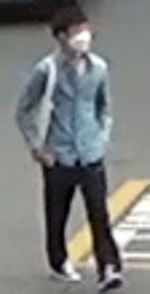
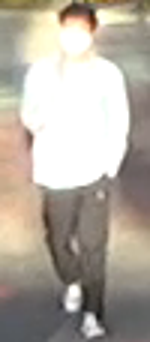
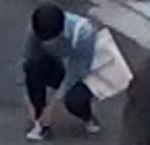

In [101]:
# H(uman) 샘플 보기
import ipyplot
h = df['H'].sample(n=1).values[0]
print(h)
sample_h = df.query('H == @h').sample(n=10)['path'].values
ipyplot.plot_images(sample_h, force_b64=True)